In [1]:
import pandas as pd
import numpy as np

movies = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, engine='python', names=['movieId', 'title', 'genres'], encoding='ISO-8859-1')
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python', names=['userId', 'movieId', 'rating', 'timestamp'], encoding='ISO-8859-1')
users = pd.read_csv('ml-1m/users.dat', sep='::', header=None, engine='python', names=['userId', 'gender', 'age', 'occupation', 'zip'], encoding='ISO-8859-1')


In [2]:

user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)


In [3]:

user_features = users.set_index('userId').drop(columns=['zip'])
user_features = pd.get_dummies(user_features, columns=['gender', 'occupation'])


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(user_movie_matrix, test_size=0.2, random_state=42)
user_features_train, user_features_test = train_test_split(user_features, test_size=0.2, random_state=42)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
user_features_train = user_features_train.astype('float32')
user_features_test = user_features_test.astype('float32')
user_movie_matrix = user_movie_matrix.astype('float32')
user_features = user_features.astype('float32')



In [5]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model


input_dim = X_train.shape[1]
user_features_dim = user_features_train.shape[1]


input_ratings = Input(shape=(input_dim,))
input_user_features = Input(shape=(user_features_dim,))


encoded = Dense(256, activation='relu')(input_ratings)
encoded = Concatenate()([encoded, input_user_features])  
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)


decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
output_ratings = Dense(input_dim, activation='sigmoid')(decoded)


autoencoder = Model(inputs=[input_ratings, input_user_features], outputs=output_ratings)
autoencoder.compile(optimizer='adam', loss='mse')


history = autoencoder.fit([X_train, user_features_train], X_train, 
                          epochs=50, 
                          batch_size=256, 
                          shuffle=True, 
                          validation_data=([X_test, user_features_test], X_test))


Epoch 1/50
19/19 [==============================] - 2s 65ms/step - loss: 0.5991 - val_loss: 0.5158
Epoch 2/50
19/19 [==============================] - 1s 35ms/step - loss: 0.5335 - val_loss: 0.5045
Epoch 3/50
19/19 [==============================] - 1s 41ms/step - loss: 0.5243 - val_loss: 0.4951
Epoch 4/50
19/19 [==============================] - 1s 48ms/step - loss: 0.5156 - val_loss: 0.4879
Epoch 5/50
19/19 [==============================] - 1s 43ms/step - loss: 0.5073 - val_loss: 0.4795
Epoch 6/50
19/19 [==============================] - 1s 39ms/step - loss: 0.4984 - val_loss: 0.4711
Epoch 7/50
19/19 [==============================] - 1s 42ms/step - loss: 0.4886 - val_loss: 0.4633
Epoch 8/50
19/19 [==============================] - 1s 37ms/step - loss: 0.4799 - val_loss: 0.4563
Epoch 9/50
19/19 [==============================] - 1s 33ms/step - loss: 0.4726 - val_loss: 0.4514
Epoch 10/50
19/19 [==============================] - 1s 33ms/step - loss: 0.4670 - val_loss: 0.4480
Epoch 11/

In [20]:

reconstructed_matrix = autoencoder.predict([user_movie_matrix, user_features])


def recommended_movies(user_id, reconstructed_matrix, user_movie_matrix, movies, n_recommendations=5):
    user_ratings = user_movie_matrix.loc[user_id]
    unseen_movies = user_ratings[user_ratings == 0].index

    user_recommendations = reconstructed_matrix[user_id - 1]
    recommendations = pd.Series(user_recommendations, index=user_movie_matrix.columns).loc[unseen_movies]
    recommended_movies = recommendations.sort_values(ascending=False).head(n_recommendations)
    recommended_movies_titles = movies[movies['movieId'].isin(recommended_movies.index)]
    
    return recommended_movies_titles[['title']]


user_id = 1
recommendations_example = recommended_movies(user_id, reconstructed_matrix, user_movie_matrix, movies, n_recommendations=10)
print(f"Recomendaciones para el usuario {user_id}")
print(recommendations_example)


189/189 [==============================] - 1s 3ms/step
Recomendaciones para el usuario 1
                                 title
33                         Babe (1995)
108                  Braveheart (1995)
315   Shawshank Redemption, The (1994)
360              Lion King, The (1994)
900                  Casablanca (1942)
2009           Jungle Book, The (1967)
2011         Lady and the Tramp (1955)
2012        Little Mermaid, The (1989)
2016             101 Dalmatians (1961)
2789            American Beauty (1999)


38/38 [==============================] - 0s 3ms/step - loss: 0.4423
Loss en el conjunto de prueba: 0.44227227568626404


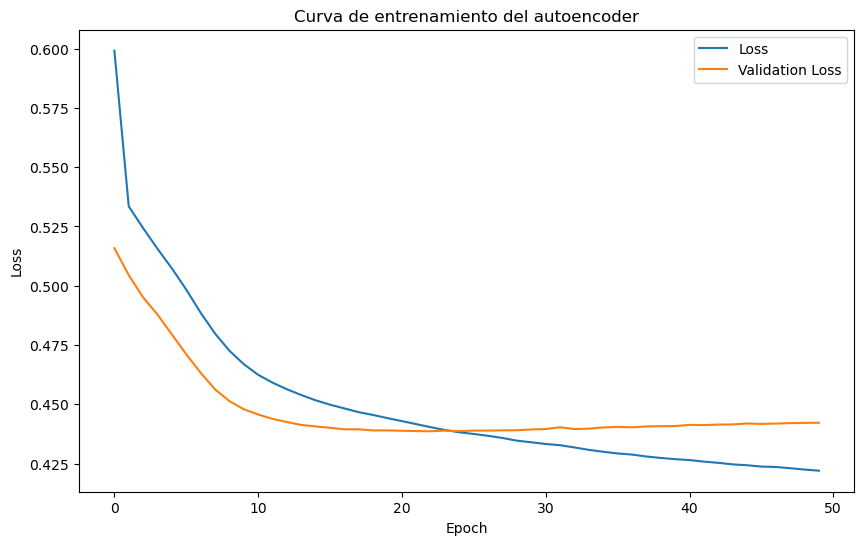

In [10]:
import matplotlib.pyplot as plt
loss = autoencoder.evaluate([X_test,user_features_test],X_test)
print(f'Loss en el conjunto de prueba: {loss}')

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Curva de entrenamiento del autoencoder')
plt.show()